# Convolutional Neural Networks (CNNs)

### HW2 @ DL Course, Dr. Soleymani

*Full Name:* Amirhossein Akbari

*SID:* 400104737

In this homework, you will work with [Google colab](https://colab.research.google.com/). Google colab allows you to run a jupyter notebook on Google servers using a GPU/TPU. To enable GPU support, make sure to press `Runtime -> Change Runtime Type -> GPU`. 

## Task: Cats vs Dogs

To learn about CNNs we will be working on a problem of great importance in computer vision, **classifying images of cats and dogs** :)

The problem is so important that there's even an easter egg in colab: go to `Tools -> Settings -> Miscellaneous and enable 'Kitty mode' and 'Corgi mode'` to get more cats and dogs to classify when you're tired of coding :)

### Getting the data

To get started with the classification, we first need to download and unpack the dataset (note that in jupyter notebooks commands starting with `!` are executed in bash, not in python):

In [1]:
! wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O ./cats_and_dogs_filtered.zip

--2024-04-01 02:48:35--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.207, 172.253.117.207, 142.250.99.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: './cats_and_dogs_filtered.zip'

./cats_and_dogs_fil 100%[===================>]  65.43M   145MB/s    in 0.5s    

2024-04-01 02:48:36 (145 MB/s) - './cats_and_dogs_filtered.zip' saved [68606236/68606236]



In [2]:
! unzip -q cats_and_dogs_filtered.zip 

### Dataset Organization
Our dataset contains two directories, `train` and `validation`, both containing two directories with images: `cats` and `dogs`. In `train` we have 1000 images of cats and 1000 images of dogs. For `validation`, we have 500 images of each class. Our goal is to implement and train a CNN to classify these images, i.e. given an image from this dataset, tell if it contains a *cat* or a *dog*.

```bash
├── dir.txt
├── train
│   ├── cats
│   │   ├── cat.0.jpg
│   │   ├── cat....jpg
│   │   ├── cat.999.jpg
│   └── dogs
│       ├── dog.0.jpg
│       ├── dog....jpg
│       ├── dog.999.jpg
├── validation
│   ├── cats
│   │   ├── cat.2000.jpg
│   │   ├── cat....jpg
│   │   └── cat.2499.jpg
│   └── dogs
│       ├── dog.2000.jpg
│       ├── dog....jpg
│       └── dog.2499.jpg
└── vectorize.py

6 directories, 3002 files
```

### Loading the data
 Now that we have the data on our disk, we need to load it so that we can use it to train our model. In Pytorch, we use `Dataset` class, documentation for which can be found [here](https://pytorch.org/docs/stable/data.html). 

 Torchvision is a Pytorch library with many commonly used tools in computer vision. In the case of computer vision, the datasets with the folder structure `label_name/image_file` are very common, and to process those there's already an implemented class `torchvision.datasets.ImageFolder` (documented [here](https://pytorch.org/vision/0.8/datasets.html)). 

 Another thing we need from Torchvision library is [transforms](https://pytorch.org/docs/stable/torchvision/transforms.html). In computer vision, we very often want to transform the images in certain ways. The most common is **normalization**. Others include *flipping*, changing *saturation*, *hue*, *contrast*, *rotation*, and *blurring*. 

 Below, we create training, validation and test sets. We use a few transforms for **augmentation** on the training set, but we don't use anything but **resize** and **normalization** for validation and test. 

In [3]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image

# These numbers are mean and std values for channels of natural images. 
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

# Inverse transformation which is needed for plotting.
inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

train_transforms = transforms.Compose([
                                    transforms.Resize((256, 256)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ColorJitter(hue=.1, saturation=.1, contrast=.1),
                                    transforms.RandomRotation(20, interpolation=Image.Resampling.BILINEAR),
                                    transforms.GaussianBlur(7, sigma=(0.1, 1.0)),
                                    transforms.ToTensor(), # This is necessary to convert PIL to torch Tensor
                                    normalize,
                                ])

validation_transforms = transforms.Compose([
                                    transforms.Resize((256, 256)),
                                    transforms.ToTensor(), 
                                    normalize,
                                ])

train_dataset = torchvision.datasets.ImageFolder('./cats_and_dogs_filtered/train', transform=train_transforms)
test_dataset = torchvision.datasets.ImageFolder('./cats_and_dogs_filtered/validation', transform=validation_transforms)

validation_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [500, 500], generator=torch.Generator().manual_seed(42))

### Dataset Inspection
Let's see what one of the images in the dataset looks like (you can run this cell multiple times to see the effects of different augmentations):

torch.Size([3, 256, 256])


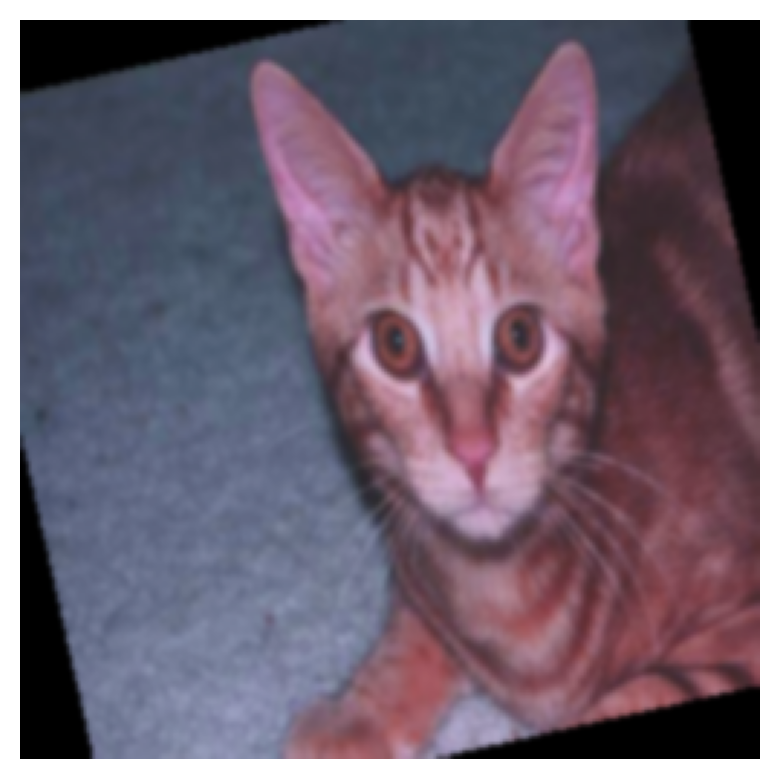

In [4]:
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 200 # change dpi to make plots bigger

def show_normalized_image(img, title=None):
    plt.imshow(inv_normalize(img).detach().cpu().permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')

print(train_dataset[10][0].shape)
show_normalized_image(train_dataset[10][0])

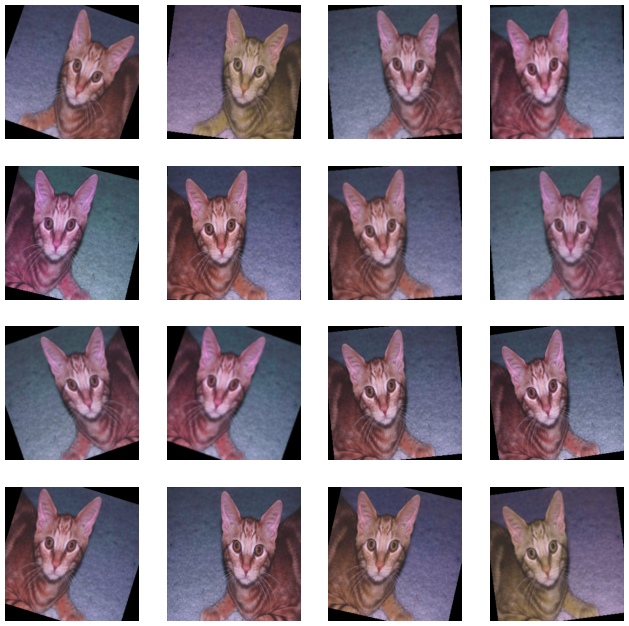

In [5]:
# checking the augmentation
plt.rcParams['figure.dpi'] = 50
plt.figure(figsize=(16,16))
for i in range(16):
    plt.subplot(4, 4, i+1)
    show_normalized_image(train_dataset[10][0])
plt.show()

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Creating the model

Now is the time to create a model. 

All models in Pytorch are subclassing `torch.nn.Module`. We have to implement `__init__` and `forward` methods. 

Below we provide a simple model skeleton, which you need to expand. The places to put your code are marked with `TODO`. Here, we ask you to implement a CNN containing the following elements:

* Convolutional layers (at least two)
* Pooling layers
* Non-linearity
* Residual connections similar to that of **ResNet**
* fully connected layer(s)

Note that you cannot use Batch Normalization layers in this step.

In [7]:
class CNN_cat_dog(torch.nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3) 
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

        self.residual1 = nn.Conv2d(64, 256, kernel_size=1, stride=2, padding=0)

        self.fc1 = nn.Linear(256 * 32 * 32, 512)  
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.pool(self.conv1(x)))
        x_res = self.residual1(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.pool(self.conv3(x)))
        x = F.relu(x + x_res) 
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


### Training the model

Now we train the model on the dataset. Again, we're providing you with the skeleton with some parts marked as `TODO` to be filled by you.

In [8]:
from tqdm.notebook import tqdm
import torch.optim as optim

def get_loss_and_correct(model, batch, criterion, device):
    inputs, labels = batch
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = model(inputs)
    loss = criterion(outputs, labels)

    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()

    return loss, correct

def step(loss, optimizer):
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [9]:
import torch
from torch import optim, nn
from tqdm.notebook import tqdm
import torch.nn.functional as F

N_EPOCHS = 50
BATCH_SIZE = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, num_workers=2)

model = CNN_cat_dog(num_classes=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) 

train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

pbar = tqdm(range(N_EPOCHS))

for epoch in pbar:
    model.train()
    total_train_loss = 0.0
    total_train_correct = 0
    total_validation_loss = 0.0
    total_validation_correct = 0


    for batch in tqdm(train_dataloader, leave=False):
        loss, correct = get_loss_and_correct(model, batch, criterion, device)
        step(loss, optimizer)
        total_train_loss += loss.item()
        total_train_correct += correct

    scheduler.step()  

    model.eval()
    with torch.no_grad():
        for batch in validation_dataloader:
            loss, correct = get_loss_and_correct(model, batch, criterion, device)
            total_validation_loss += loss.item()
            total_validation_correct += correct

    mean_train_loss = total_train_loss / len(train_dataloader)
    train_accuracy = total_train_correct / len(train_dataset)

    mean_validation_loss = total_validation_loss / len(validation_dataloader)
    validation_accuracy = total_validation_correct / len(validation_dataset)

    train_losses.append(mean_train_loss)
    train_accuracies.append(train_accuracy)
    validation_losses.append(mean_validation_loss)
    validation_accuracies.append(validation_accuracy)

    pbar.set_postfix({'train_loss': mean_train_loss, 'validation_loss': mean_validation_loss, 'train_accuracy': train_accuracy, 'validation_accuracy': validation_accuracy})


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Now that the model is trained, we want to visualize the training and validation losses and accuracies:

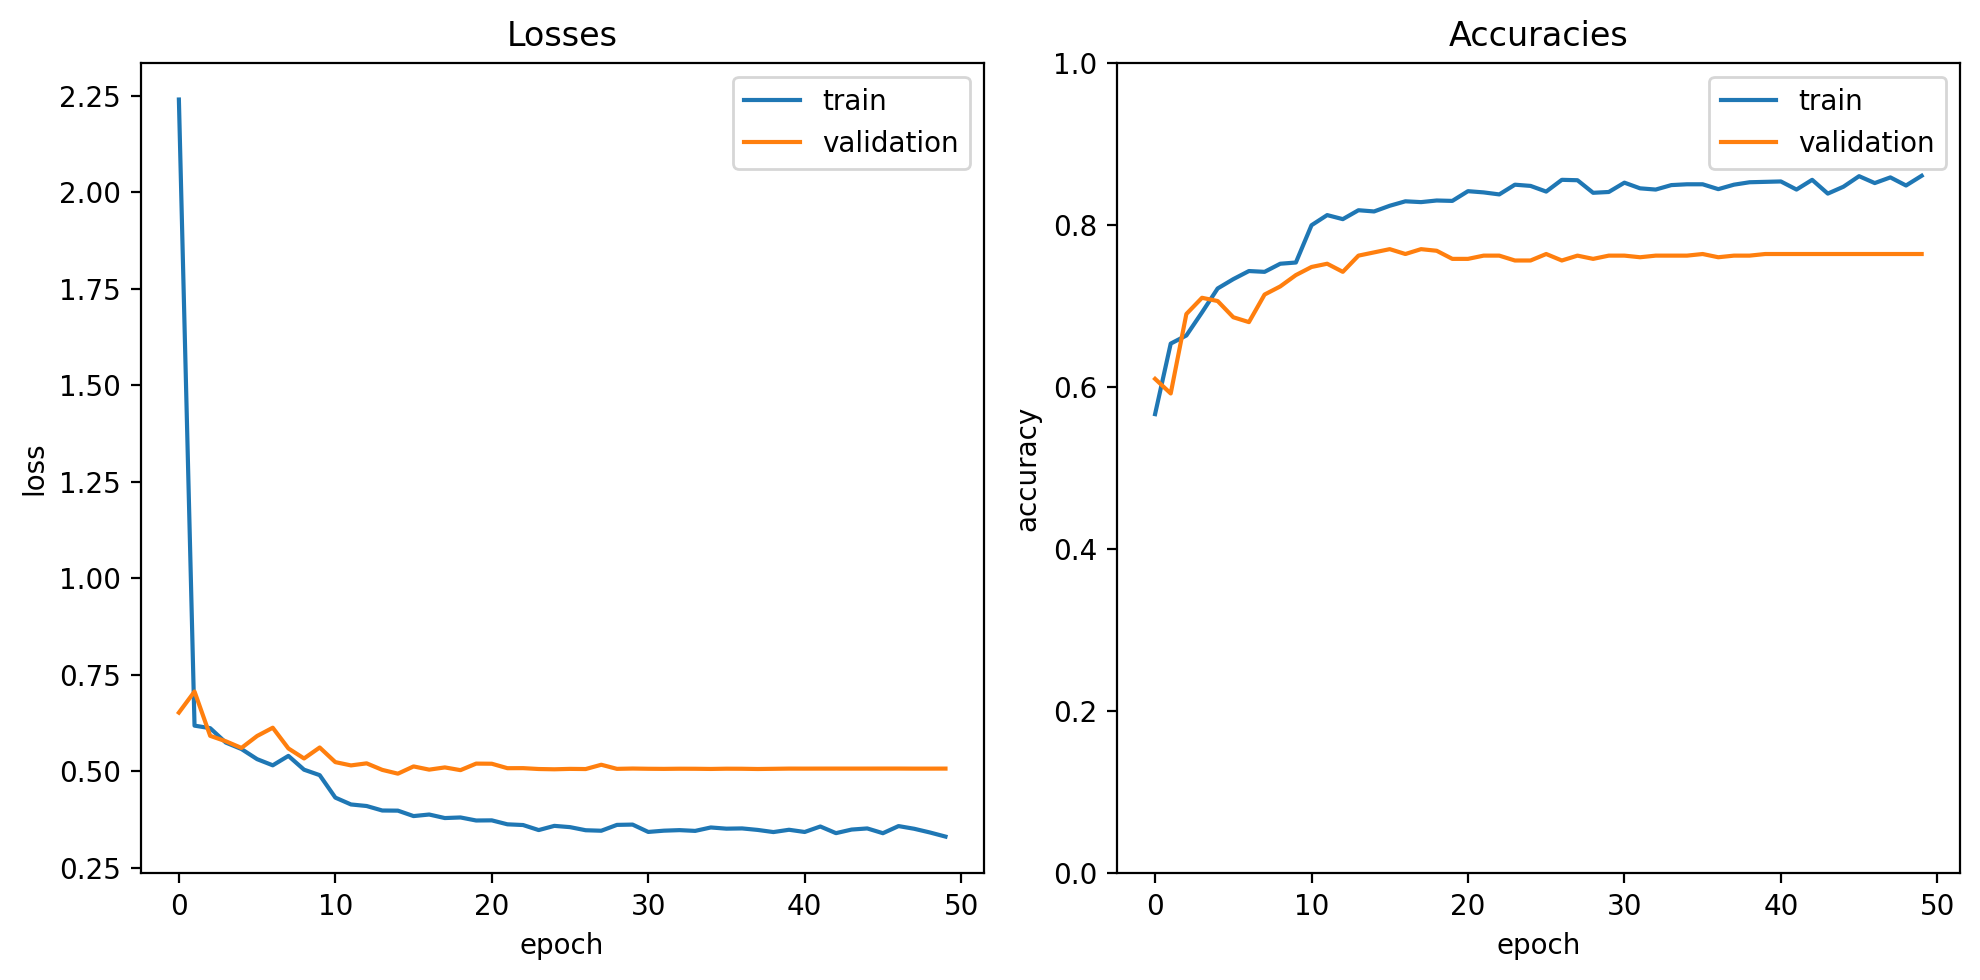

In [10]:
plt.figure(dpi=200, figsize=(10, 5))

plt.subplot(121)
plt.plot(train_losses, label='train')
plt.plot(validation_losses, label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Losses')
plt.legend()

plt.subplot(122)
plt.plot(train_accuracies, label='train')
plt.plot(validation_accuracies, label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.title('Accuracies')

plt.tight_layout()
plt.show()

Now, change your model to achieve at least 75% accuracy on validation set. Add Dropout and Batch Norm layers where needed. You can change the model you've implemented (including the model depth, activation functions, etc.), the optimizer (including the regularizer terms), and the augmentations. 

#### Question
Looking at the loss and accuracy plots, can you see if your model overfits the trainig set? Why?

When examining loss and accuracy plots to determine if a model overfits the training set, particularly without any normalization, key indicators include a continuously decreasing training loss alongside stagnant or increasing validation loss. Similarly, if the training accuracy keeps improving while the validation accuracy plateaus or decreases, it suggests the model is memorizing the training data rather than generalizing from it. The absence of normalization could exacerbate overfitting, as the model may become overly sensitive to the scale and distribution of input features, further hindering its ability to generalize to unseen data.

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class EnhancedResNet(nn.Module):
    def __init__(self, num_classes=2):
        super(EnhancedResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        return x


In [13]:
import torch
from torch import optim, nn
from tqdm.notebook import tqdm
import torch.nn.functional as F

N_EPOCHS = 15
BATCH_SIZE = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, num_workers=2)

model2 = EnhancedResNet(num_classes=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.0002, betas=(0.5, 0.999))

train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

pbar = tqdm(range(N_EPOCHS))

for epoch in pbar:
    model2.train()
    total_train_loss = 0.0
    total_train_correct = 0
    total_validation_loss = 0.0
    total_validation_correct = 0


    for batch in tqdm(train_dataloader, leave=False):
        loss, correct = get_loss_and_correct(model2, batch, criterion, device)
        step(loss, optimizer)
        total_train_loss += loss.item()
        total_train_correct += correct


    model2.eval()
    with torch.no_grad():
        for batch in validation_dataloader:
            loss, correct = get_loss_and_correct(model2, batch, criterion, device)
            total_validation_loss += loss.item()
            total_validation_correct += correct

    mean_train_loss = total_train_loss / len(train_dataloader)
    train_accuracy = total_train_correct / len(train_dataset)

    mean_validation_loss = total_validation_loss / len(validation_dataloader)
    validation_accuracy = total_validation_correct / len(validation_dataset)

    train_losses.append(mean_train_loss)
    train_accuracies.append(train_accuracy)
    validation_losses.append(mean_validation_loss)
    validation_accuracies.append(validation_accuracy)

    pbar.set_postfix({'train_loss': mean_train_loss, 'validation_loss': mean_validation_loss, 'train_accuracy': train_accuracy, 'validation_accuracy': validation_accuracy})


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

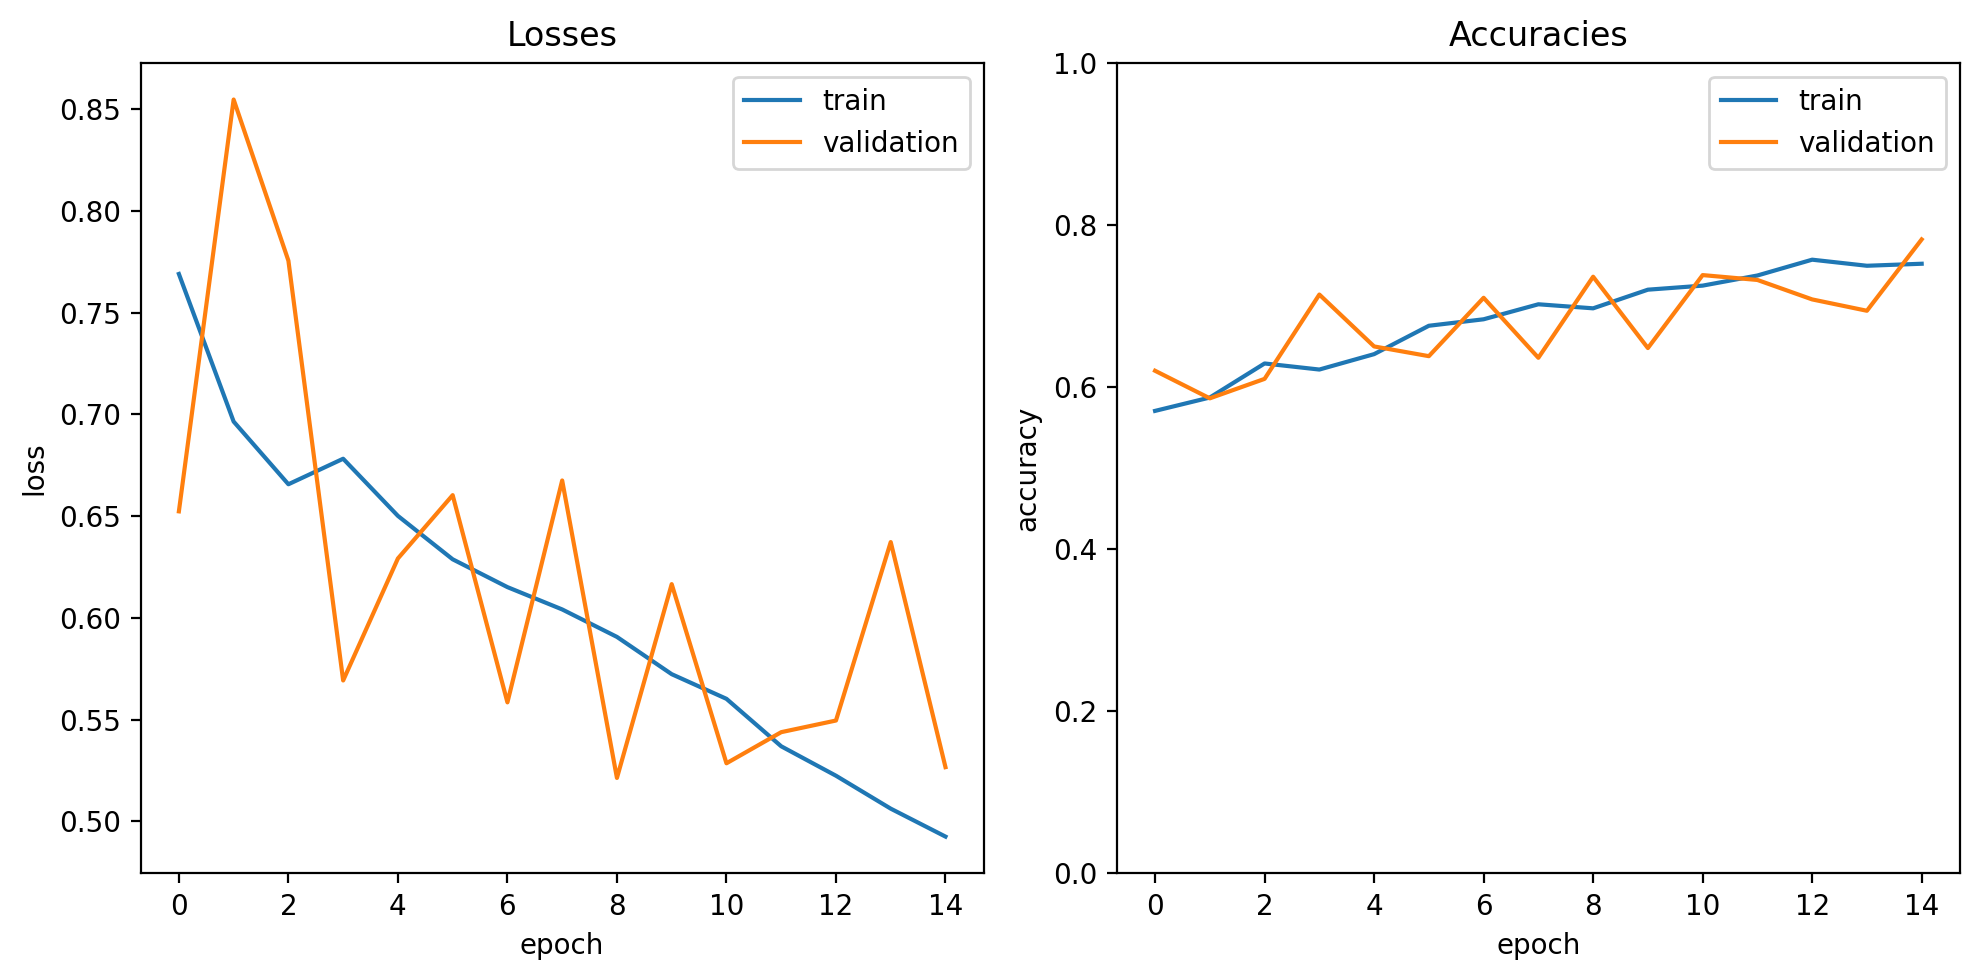

In [14]:
plt.figure(dpi=200, figsize=(10, 5))

plt.subplot(121)
plt.plot(train_losses, label='train')
plt.plot(validation_losses, label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Losses')
plt.legend()

plt.subplot(122)
plt.plot(train_accuracies, label='train')
plt.plot(validation_accuracies, label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.title('Accuracies')

plt.tight_layout()
plt.show()

### Testing the model

Now, use the `test_dataset` to get the final accuracy of your model. Visualize some correctly and incorrectly classified examples.

In [15]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=2)

model.eval() 
total_test_correct = 0
total_test_loss = 0.0

with torch.no_grad():
    for batch in test_dataloader:
        loss, correct = get_loss_and_correct(model, batch, criterion, device)
        total_test_loss += loss.item()
        total_test_correct += correct

mean_test_loss = total_test_loss / len(test_dataloader)
test_accuracy = total_test_correct / len(test_dataset)
print(f'Test Loss: {mean_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.5052, Test Accuracy: 0.7820


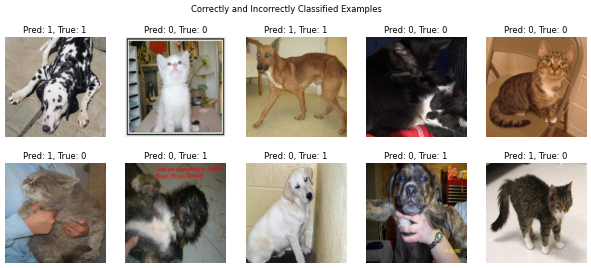

In [16]:
def visualize_predictions(model, dataloader, device, num_images=5):
    model.eval()
    correct_images, incorrect_images = [], []
    correct_preds, incorrect_preds = [], []
    true_labels_correct, true_labels_incorrect = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            matches = predicted == labels

            for i, match in enumerate(matches):
                if match and len(correct_images) < num_images:
                    correct_images.append(images[i].cpu())
                    correct_preds.append(predicted[i].cpu())
                    true_labels_correct.append(labels[i].cpu())
                elif not match and len(incorrect_images) < num_images:
                    incorrect_images.append(images[i].cpu())
                    incorrect_preds.append(predicted[i].cpu())
                    true_labels_incorrect.append(labels[i].cpu())

                if len(correct_images) >= num_images and len(incorrect_images) >= num_images:
                    break
            if len(correct_images) >= num_images and len(incorrect_images) >= num_images:
                break

    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))
    fig.suptitle('Correctly and Incorrectly Classified Examples')

    for i, (img, pred, label) in enumerate(zip(correct_images, correct_preds, true_labels_correct)):
        img = inv_normalize(img)
        axes[0, i].imshow(img.permute(1, 2, 0))
        axes[0, i].set_title(f'Pred: {pred}, True: {label}')
        axes[0, i].axis('off')

    for i, (img, pred, label) in enumerate(zip(incorrect_images, incorrect_preds, true_labels_incorrect)):
        img = inv_normalize(img) 
        axes[1, i].imshow(img.permute(1, 2, 0))
        axes[1, i].set_title(f'Pred: {pred}, True: {label}')
        axes[1, i].axis('off')

    plt.show()

visualize_predictions(model, test_dataloader, device)


### Visualizing filters

In this part, we are going to visualize the output of one of the convolutional layers to see what features they focus on.

First, let's get some image.

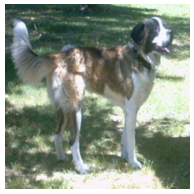

In [17]:
input_image = validation_dataset[10][0]
show_normalized_image(input_image)

Now, we are going to *clip* our model at different points to get different intermediate representation. 
* Clip your model at two or three different points and plot the filters output.

In order to clip the model, you can use `model.children()` method. For example, to get output only after the first 4 layers, you can do:

```
clipped = nn.Sequential(
    *list(model.children()[:2])
)
intermediate_output = clipped(input)
```



torch.Size([1, 64, 128, 128])


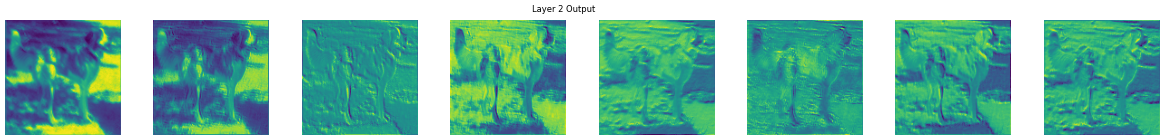

torch.Size([1, 64, 64, 64])


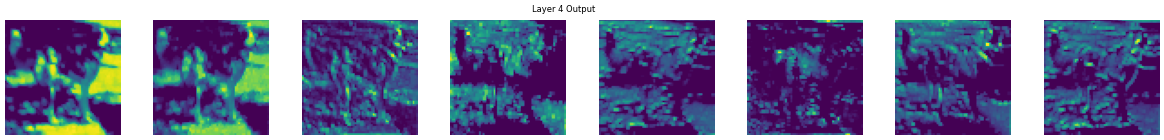

torch.Size([1, 128, 32, 32])


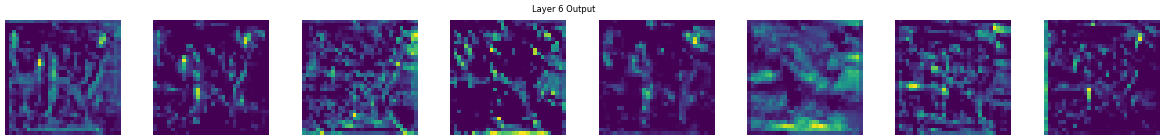

In [18]:
def visualize_layer_outputs(model, input_image, layer_indices):
    outputs = []
    names = []
    for i in layer_indices:
        clipped = nn.Sequential(*list(model.children())[:i])
        intermediate_output = clipped(input_image)
        outputs.append(intermediate_output)
        names.append(f'Layer {i} Output')

    for output, name in zip(outputs, names):
        print(output.size())
        plt.figure(figsize=(30, 3))
        layer_output = output[0].detach().cpu()
        num_channels = layer_output.shape[0]
        for i in range(min(num_channels, 8)):
            plt.subplot(1, min(num_channels, 8), i+1)
            plt.imshow(layer_output[i])
            plt.axis('off')
        plt.suptitle(name)
        plt.show()

visualize_layer_outputs(model2.to(device), input_image.unsqueeze(0).to(device), [2, 4, 6])


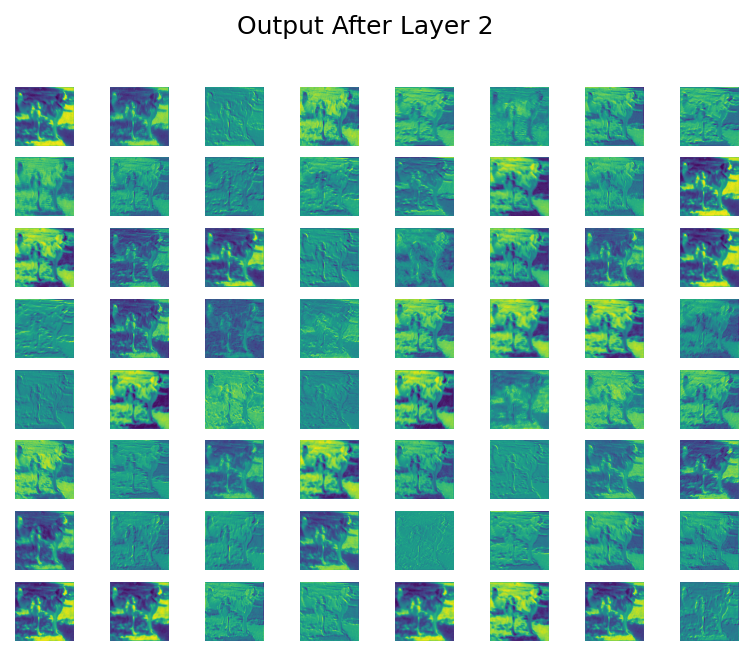

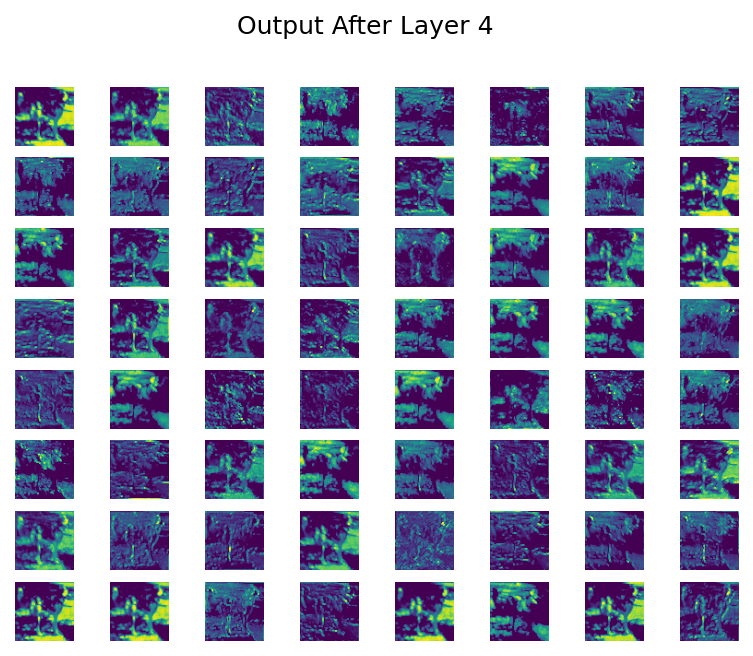

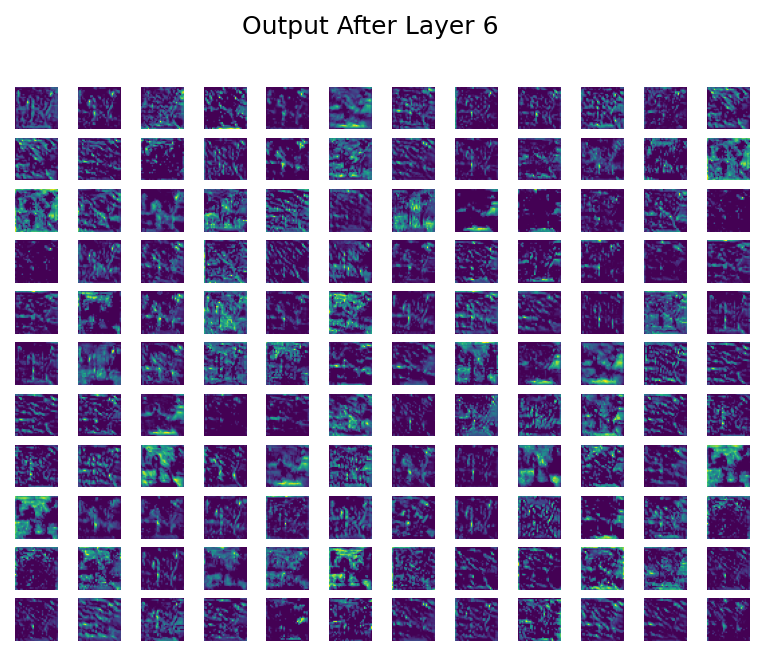

In [19]:
import math

def plot_intermediate_output(result, title=None):
    """ Plots the intermediate output of shape
      N_FILTERS x H x W
    """
    plt.rcParams['figure.dpi'] = 150
    n_filters = result.shape[1]
    N = int(math.sqrt(n_filters))
    M = (n_filters + N - 1) // N
    assert N * M >= n_filters

    fig, axs = plt.subplots(N, M)
    fig.suptitle(title)

    for i in range(N):
        for j in range(M):
            if i*N + j < n_filters:
                axs[i][j].imshow(result[0, i*N + j].cpu().detach())
                axs[i][j].axis('off')

layer_indices = [2, 4, 6]

for index in layer_indices:
    clipped_model = torch.nn.Sequential(*list(model2.children())[:index])
    clipped_model = clipped_model.to(device)
    with torch.no_grad():
        intermediate_output = clipped_model(input_image.unsqueeze(0).to(device))
    plot_intermediate_output(intermediate_output, title=f'Output After Layer {index}')

### Question
What can you say about those filters? What features are they focusing on?

The filters displayed from layers 4 and 6 of My CNN model, when applied to the image of the dog, appear to capture a variety of features. The earlier layer's filters (Layer 4) seem to be focusing on lower-level features such as edges and textures, as evidenced by the clear outlines and patterns resembling parts of the dog and its surroundings. The filters from the later layer (Layer 6), however, show more abstract representations, which are likely capturing higher-level features. These could correspond to more complex aspects of the image, like the shape of the dog or the distinction between the dog and the background, though it's more difficult to interpret specific features at this level due to their abstract nature. Overall, the filters seem to act progressively, capturing increasingly complex features as the layers go deeper.